In [513]:
# packages for working with data
import pandas as pd
import json
from datetime import timedelta
import numpy as np
from collections import OrderedDict

# visualization tools
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.5)

# tools for building predictive model
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Part 1 - Exploratory Data Analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular geographic location. Aggregate these login counts based on 15minute time intervals, and visualize and describe the resulting time series of login counts in ways that best characterize the underlying patterns of the demand. Please report/illustrate important features of the demand, such as daily cycles. If there are data quality issues, please report them.

In [98]:
# Load the dataset
logins = pd.read_json('logins.json')

First I will preview the structure and details of the data that I will be working with.

In [103]:
# get info on data entries and columns
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
login_time    93142 non-null datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [99]:
# Preview first few rows of data
logins.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


The data only has one column and is already conveniently in a datetime format.

In [104]:
# Display the timespan of data
begin_time = logins.iloc[0].login_time
final_time = logins.iloc[-1].login_time

print('Beginning Time of this data set: {0}'.format(begin_time))
print('Ending Time of this data set: {0}'.format(final_time))
print('Total timespan: {0}'.format(final_time - begin_time))

Beginning Time of this data set: 1970-01-01 20:13:18
Ending Time of this data set: 1970-04-13 18:54:23
Total timespan: 101 days 22:41:05


The dataset covers a timespan of about 100 days. Next I will resample the data at 15 minute intervals to get the count of logins for those periods.

In [106]:
# Display preview of logins, sampled every 15 minutes
counts = logins.resample('15T', on='login_time').count()

print(counts.head())

                     login_time
login_time                     
1970-01-01 20:00:00           2
1970-01-01 20:15:00           6
1970-01-01 20:30:00           9
1970-01-01 20:45:00           7
1970-01-01 21:00:00           1


In [114]:
counts.shape

(9788, 1)

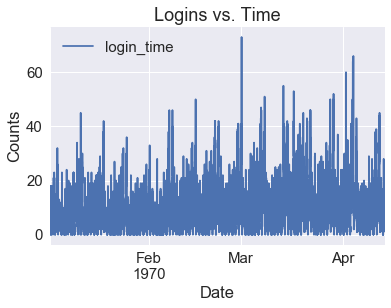

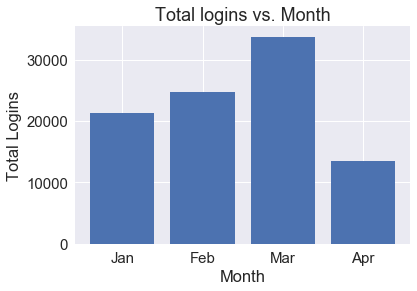

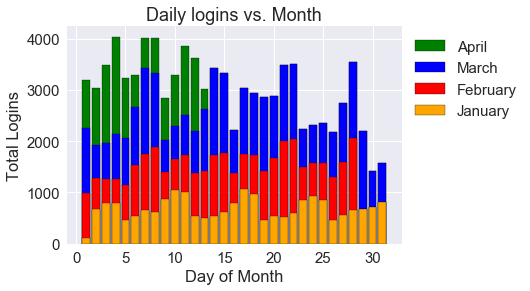

In [194]:
# generate visualization of login counts over time
counts.plot(kind='line')
plt.title('Logins vs. Time')
plt.xlabel('Date')
plt.ylabel('Counts')

plt.show()

# generate bar graph of login counts vs. months
monthly = [counts[counts.login_time.index.month == x].login_time.sum() for x in range(1,5)]
plt.bar(range(1,5), monthly)

plt.title('Total logins vs. Month')
plt.xlabel('Month')
plt.xticks(range(1,5), ['Jan', 'Feb', 'Mar', 'Apr'])
plt.ylabel('Total Logins')

plt.show()

# geneate bar graph of average login counts vs. day of month
# separate daily counts for each month
jan_daily = [counts[(counts.login_time.index.day == x) & (counts.login_time.index.month == 1)].login_time.sum() for x in range(1,32)]
feb_daily = [counts[(counts.login_time.index.day == x) & (counts.login_time.index.month == 2)].login_time.sum() for x in range(1,32)]
mar_daily = [counts[(counts.login_time.index.day == x) & (counts.login_time.index.month == 3)].login_time.sum() for x in range(1,32)]
apr_daily = [counts[(counts.login_time.index.day == x) & (counts.login_time.index.month == 4)].login_time.sum() for x in range(1,32)]

# create stacked bars for plot
jan_feb = [sum(x) for x in zip(jan_daily, feb_daily)]
jan_feb_mar = [sum(x) for x in zip(jan_daily, feb_daily, mar_daily)]
total_daily = [sum(x) for x in zip(jan_daily, feb_daily, mar_daily, apr_daily)]

# plot stacked bar graph
plt.bar(range(1,32), total_daily, edgecolor='k', facecolor='g', label='April')
plt.bar(range(1,32), jan_feb_mar, edgecolor='k', facecolor='b', label='March')
plt.bar(range(1,32), jan_feb, edgecolor='k', facecolor='r', label='February')
plt.bar(range(1,32), jan_daily, edgecolor='k', facecolor='orange', label='January')
plt.legend(loc='best', bbox_to_anchor=(1,1))

plt.title('Daily logins vs. Month')
plt.xlabel('Day of Month')
plt.ylabel('Total Logins')

plt.show()

# Part 2 - Experiment and Metrics Design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active during the day. On weekends, there is reasonable activity in both cities. 

However, a toll bridge, with a two way toll, between the two cities causes driver partners to tend to be exclusive to each city. The Ultimate managers of city operations for the two cities have proposed an experiment to encourage driver partners to be available in both cities, by reimbursing all toll costs.  

1. **What would you choose as the key measure of success of this experiment in encouraging driver partners to serve both cities, and why would you choose this metric?**  
    The key measure of success could simply be an increase in the total use of tolls for both directions between the cities.  

2. **Describe a practical experiment you would design to compare the effectiveness of the proposed change in relation to the key measure of success. Please provide details on:**  

    a. **how you will implement the experiment**  
    Given that we have sufficient data from the tolls before we make a change, we can observe daily and hourly counts in the usage of tolls in both directions.
    
    b. **what statistical test(s) you will conduct to verify the significance of the observation**  
    We can implement A/B testing to compare usage of the tolls in both directions at different times of day. During the day, we should expect to see a rise in toll traffic from Gotham to Metropolis, since the most activity should be there, going into nighttime, we should expect to see a rise in the percentage of toll usage toward Gotham. On weekends, we can compare to see if there is an overall increase in toll usage, and observe the balance between the two before and after the changes we implement.
    
    c. **how you would interpret the results and provide recommendations to the city operations team along with any caveats**  
    If the results are as we expect, we can provide an initial report on the effects of the implementation of the project. If one of the results do not reflect an improvement as expected, such as traffic increase from Gotham to Metropolis being less than that from Metropolis to Gotham. We can suggest to examine driver activity individually in each city to see how profitable business is within the cities.

# Part 3 - Predictive Modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have provided a sample dataset of a cohort of users who signed up for an Ultimate account in January 2014. The data was pulled several months later; we consider a user retained if they were “active” (i.e. took a trip) in the preceding 30 days.

We would like you to use this data set to help understand what factors are the best predictors for retention, and offer suggestions to operationalize those insights to help Ultimate. The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

The data is in the attached file ultimate_data_challenge.json. See below for a detailed description of the dataset. Please include any code you wrote for the analysis and delete the dataset when you have finished with the challenge.

#### 1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

First I will load the dataset and see the general structure of what I am working with.

In [425]:
# Load dataset
with open('ultimate_data_challenge.json') as f:
    json_data = json.load(f)

# Convert data to DataFrame
data = pd.DataFrame(json_data)

In [426]:
# Display data information
data.info()

# Preview first few rows of data
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


It looks like there are some null entries in the "phone", "avg_rating_of_driver" and "avg_rating_by_driver". I will look into the statistics and distribution of each column before deciding what to do about these missing values.

In [427]:
# Display statistics on numerical columns
data.describe()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,weekday_pct
count,50000.000000,49799.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,5.796827,4.778158,4.601559,1.074764,8.849536,2.278200,60.926084
std,5.707357,0.446652,0.617338,0.222336,19.958811,3.792684,37.081503
min,0.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.420000,4.700000,4.300000,1.000000,0.000000,0.000000,33.300000
50%,3.880000,5.000000,4.900000,1.000000,0.000000,1.000000,66.700000
75%,6.940000,5.000000,5.000000,1.050000,8.600000,3.000000,100.000000
max,160.960000,5.000000,5.000000,8.000000,100.000000,125.000000,100.000000


Some of the columns have much larger ranges than others, so it will be best to normalize these later on before building our models. For now they will be left as is.

City Categories:
Winterfell        23336
Astapor           16534
King's Landing    10130
Name: city, dtype: int64


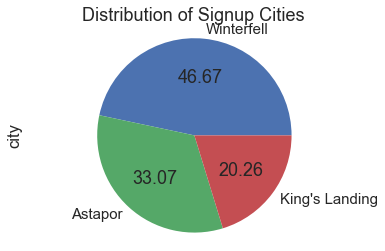


Phone Categories:
iPhone     34582
Android    15022
Name: phone, dtype: int64


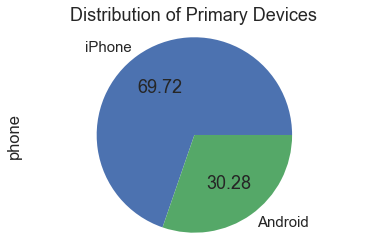


Ultimate Black User?
False    31146
True     18854
Name: ultimate_black_user, dtype: int64


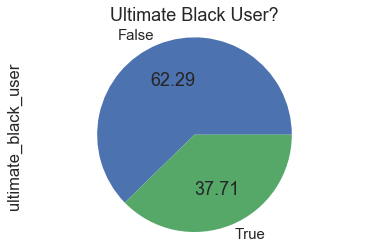

In [428]:
# Display information on categorical columns

# Display information on  City column
print('City Categories:')
print(data.city.value_counts())

data.city.value_counts().plot.pie(autopct='%.2f')
plt.title('Distribution of Signup Cities')
plt.axis('equal')
plt.show()

# Display information on phone column
print('\nPhone Categories:')
print(data.phone.value_counts())

data.phone.value_counts().plot.pie(autopct='%.2f')
plt.title('Distribution of Primary Devices')
plt.axis('equal')
plt.show()

# Display information on ultimate_black_user column
print('\nUltimate Black User?')
print(data.ultimate_black_user.value_counts())

data.ultimate_black_user.value_counts().plot.pie(autopct='%.2f')
plt.title('Ultimate Black User?')
plt.axis('equal')
plt.show()

Finally, I will begin to format and clean the data for EDA using the following steps:

1. Find and remove duplicate entries
2. Format datetime columns
3. Drop the small number of entries without a phone (since it is less than 1% of the data)
4. Change "phone" column to "iPhone" boolean column (1 for iPhone, 0 for Android)
5. Add column indicating whether or not user is active in the past 30 days (if trip was taken: 1, otherwise: 0)

In [429]:
# Check for duplicate entries
print('Number of duplicate entries: {0}'.format(data.duplicated().sum()))

# Drop the duplicate entries
data.drop(data[data.duplicated()].index, axis=0, inplace=True)
print('---Duplicate entries dropped!---')

Number of duplicate entries: 8
---Duplicate entries dropped!---


In [430]:
# format datetime columns
data.last_trip_date = pd.to_datetime(data.last_trip_date, infer_datetime_format=True)
data.signup_date = pd.to_datetime(data.signup_date, infer_datetime_format=True)
print('---Datetime columns formatted!---')

---Datetime columns formatted!---


In [431]:
# drop entries with no phone information
print('Number of entries with no phone info: {0}'.format(data.phone.isnull().sum()))

data.drop(data[data.phone.isnull()].index, axis=0, inplace=True)
print('---NA phone entries dropped!---')

Number of entries with no phone info: 396
---NA phone entries dropped!---


In [432]:
# Create a boolean value for customers that use (or do not use) iphones
iphone_bool = [1 if data.phone.iloc[i] == 'iPhone' else 0 for i in range(data.shape[0])]

# Add column to list and drop original column
data['iphone'] = iphone_bool
data.drop('phone', axis=1, inplace=True)

In [433]:
# Find date ranges of the data
print('The data ranges from {0} to {1}'.format(min(data.signup_date), max(data.last_trip_date)))

The data ranges from 2014-01-01 00:00:00 to 2014-07-01 00:00:00


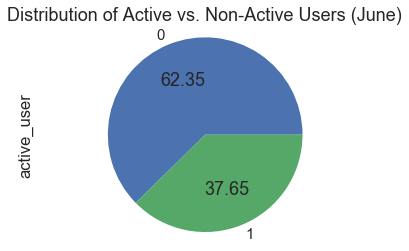

In [434]:
# Create a column with 1 value entries if last trip date is within last 30 days, 0 otherwise
active_cutoff = (max(data.last_trip_date) - timedelta(days=30))
active_users = [1 if data.last_trip_date.iloc[i] >= active_cutoff else 0 for i in range(data.shape[0])]

# Add new columns to data
data['active_user'] = active_users

# plot new column
data.active_user.value_counts().plot.pie(autopct = '%.2f')
plt.axis('equal')
plt.title('Distribution of Active vs. Non-Active Users (June)')

plt.show()

Next we will format the data so that it will not cause problems later. First, the missing entries in the avg_rating columns will be filled in with the mean value for each column.

In [472]:
# Fill missing values with mean rating for rating columns
fill_values = {'avg_rating_by_driver': round(np.mean(data.avg_rating_by_driver),1),
               'avg_rating_of_driver': round(np.mean(data.avg_rating_of_driver),1)}
data.fillna(value=fill_values, inplace=True);

In [440]:
# Change last_trip_date column to # of days since activity format
cutoff_date = datetime(2014, 7, 1)
days_inactive = data.last_trip_date.map(lambda x: (cutoff_date - x).days)

# Replace last_trip_date column
data['days_inactive'] = days_inactive
data.drop('last_trip_date', axis=1, inplace=True)

In [445]:
# Change signup_date to day of signup (1-31)
signup_day = data.signup_date.map(lambda x: x.day)

# Replace signup_date column
data['signup_date'] = signup_day

Now that some formatting has been done, the columns will be investigated.

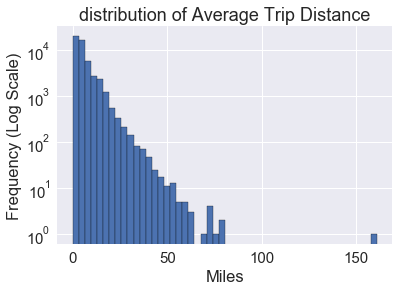

In [446]:
plt.hist(data.avg_dist, edgecolor='k', bins=50)
plt.yscale('log')
plt.title('distribution of Average Trip Distance')
plt.ylabel('Frequency (Log Scale)')
plt.xlabel('Miles')

plt.show()

There's an outlier in the avg_dist column above 150 miles. I will remove this entry.

In [447]:
# Drop the outlier data point in the average trip distance column
data.drop(data[data.avg_dist > 150].index, axis=0, inplace=True)

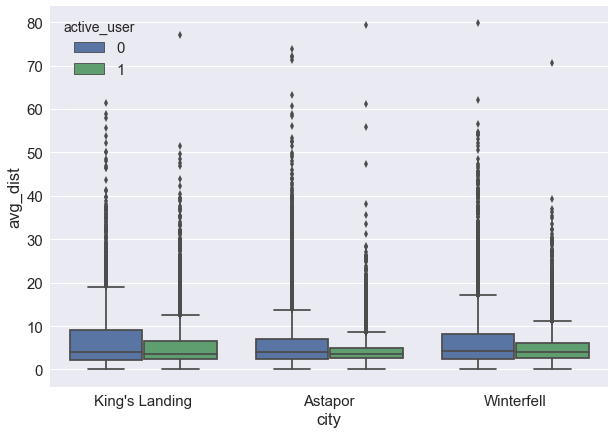

In [448]:
plt.subplots(figsize=(10,7))
sns.boxplot(x='city', y='avg_dist', hue='active_user', data=data)

plt.show()

On average, it looks like active users take shorter trips than inactive users, although it is difficult to tell the difference between users that signed up in different regions. To oget a better idea of the predictors that are significant to retention rates, I will use a predictive machine learning model.

Before that, there is one last step that should be performed. The column "city" will be converted to OHE, with the "Astapor City" dropped to ensure model stability.

In [458]:
# OHE of city column
data = pd.get_dummies(data, columns=['city'], drop_first=True)

And finally check our dataset info to make sure that all columns have been formatted correctly.

In [459]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49595 entries, 0 to 49999
Data columns (total 14 columns):
avg_dist                  49595 non-null float64
avg_rating_by_driver      49398 non-null float64
avg_rating_of_driver      41573 non-null float64
avg_surge                 49595 non-null float64
signup_date               49595 non-null int64
surge_pct                 49595 non-null float64
trips_in_first_30_days    49595 non-null int64
ultimate_black_user       49595 non-null bool
weekday_pct               49595 non-null float64
iphone                    49595 non-null int64
active_user               49595 non-null int64
days_inactive             49595 non-null int64
city_King's Landing       49595 non-null uint8
city_Winterfell           49595 non-null uint8
dtypes: bool(1), float64(6), int64(5), uint8(2)
memory usage: 5.9 MB


#### 2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

To predict the active users for this data I will be using the random forest model. It is a good choice for this because it can produce interpretable insights that can help form suggestions based on feature importances, and can make quick predictions once trained. It also compromises between training speed and accuracy, so I will be able to iterate over and optimize the hyperparameters in order to increase the performance of the model.

First, I will split the data into training and cross-validation sets.

In [516]:
# Normalize data for model
norm_X = normalize(data.drop(['active_user', 'days_inactive'], axis=1))

# Split data into train and CV sets
X_train, X_CV, y_train, y_CV = train_test_split(norm_X, data.active_user, test_size=0.2, random_state=12)

In [517]:
# Set up random forest
rf_clf = RandomForestClassifier(n_estimators=200, oob_score=True, n_jobs=-1,
                                random_state=42, verbose=1, class_weight='balanced')
rf_clf.fit(X_train, y_train)
preds = rf_clf.predict(X_CV)
print(classification_report(y_CV, preds))
print('Out-of-bag generalization accuracy estimate: {0:.2f} %'.format(rf_clf.oob_score_))

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:   10.0s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


             precision    recall  f1-score   support

          0       0.79      0.84      0.82      6164
          1       0.71      0.63      0.67      3755

avg / total       0.76      0.76      0.76      9919

Out-of-bag generalization accuracy estimate: 0.77 %


Shown above is the classification report for the random forest model. We can see that there is reasonably good performance for both precision and recall, but further tuning will require us to know if the situation calls for us to more accurately identify users that may not be active, so that we may take steps to keep them, or to identify users that will be active, which would be useful in planning operations for the next month.

We can also visualize the performance by looking at a confusion matrix, shown below:

In [521]:
print(confusion_matrix(y_CV, preds))

[[5208  956]
 [1380 2375]]


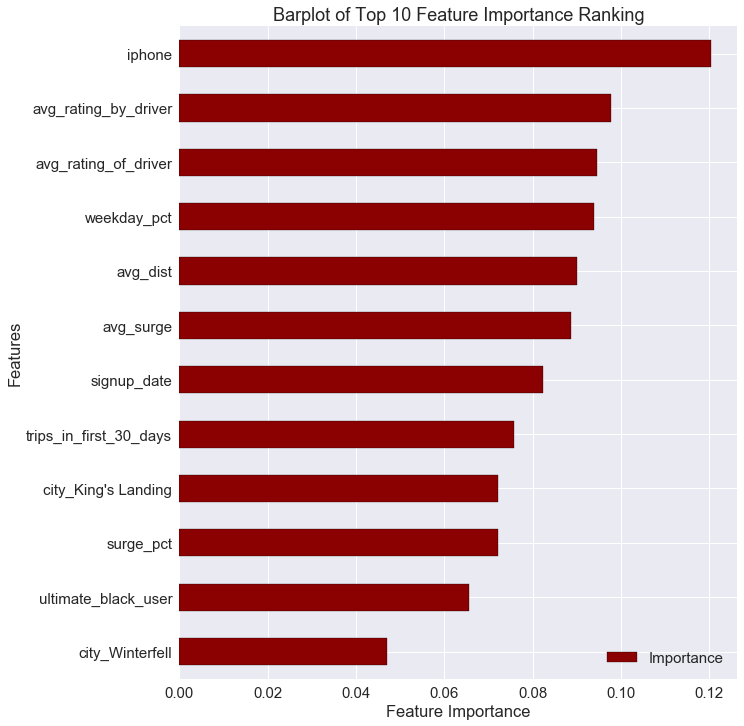

In [520]:
# Plot feature importances for random forest
features = data.drop(['active_user', 'days_inactive'], axis=1).columns.values

importance_df = pd.DataFrame(
    data = {'features': features,
            'Importance': rf_clf.feature_importances_
           }
).sort_values(by='Importance',
              ascending=True)

# Set the index for the importance dataframe
importance_df.set_index('features', inplace=True)

# Generate horizontal bar plot
importance_df.plot(kind='barh', figsize=(10, 12), facecolor='DarkRed', edgecolor='k')

# Plot formatting
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Barplot of Top 10 Feature Importance Ranking')

plt.show()

#### 3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its longterm rider retention (again, a few sentences will suffice)

The analysis and model that has been built suggests that the primary device is the most significant predictor of whether or not a user will be retained. This could be due to differencess in the app performance across platforms, and should be addressed. Also, average ratings both by and oof drivers scored highly in importance. It may be that driver satisfaction and overall morale, or stricter guidelines in the choosing of driver personel can greatly influence whether users will stay or not. This makes sense since drivers are the face of the company in the eyes of the customers.